class

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow_datasets as tfds

# Load the cats_vs_dogs dataset
(train_ds, validation_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

# Get class names
class_names = ['cat', 'dog']

# Display dataset info
print(info)

# Show the number of examples
print(f"Total training examples: {info.splits['train'].num_examples * 0.8}")
print(f"Total validation examples: {info.splits['train'].num_examples * 0.2}")

TensorFlow version: 2.18.0


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.E9CH2Y_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings 

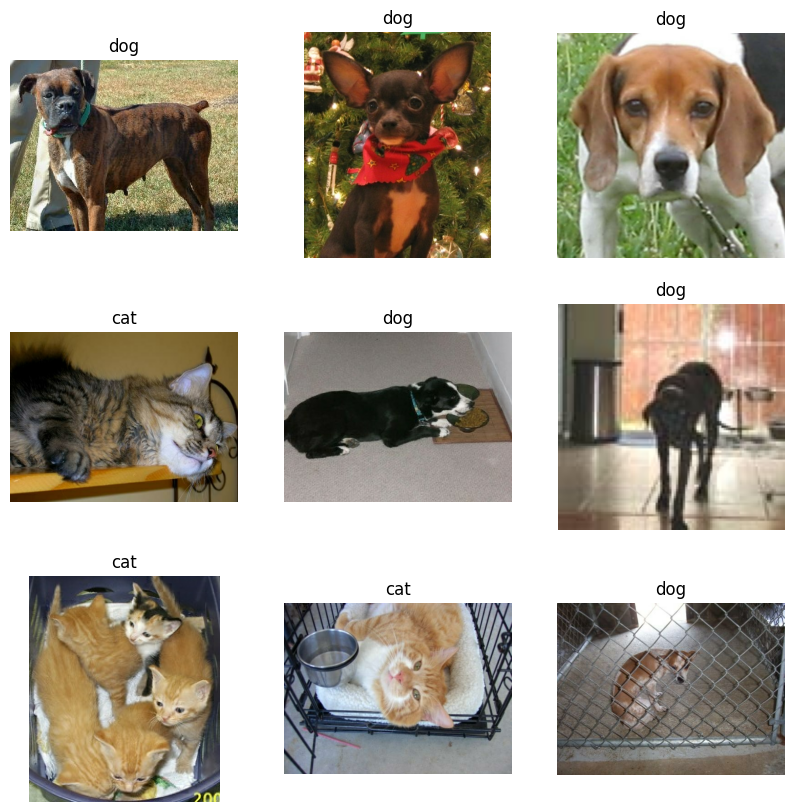

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")
plt.show()

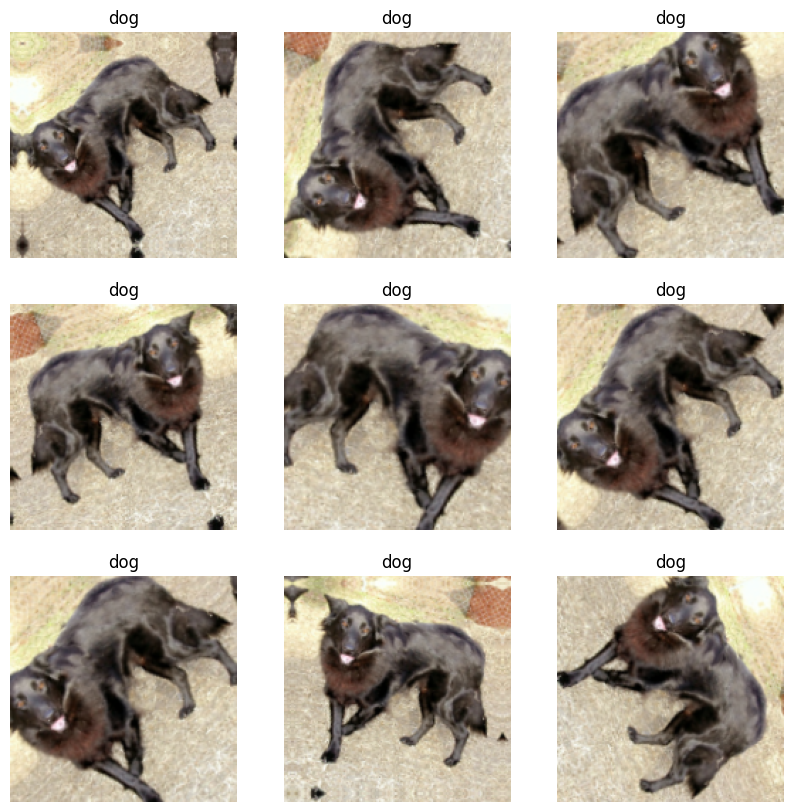

In [ ]:
IMG_SIZE = 160  # All images will be resized to 160x160

def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normalize pixel values to [0,1]
    image = image / 255.0
    return image, label

# Apply preprocessing to datasets
train_ds = train_ds.map(preprocess_image)
validation_ds = validation_ds.map(preprocess_image)

# Optimize for performance
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_ds = validation_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Visualize augmented images
plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.title(class_names[label[0]])
        plt.axis('off')
plt.show()

In [ ]:
# Create the base model from a pre-trained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create the model architecture
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Data augmentation layers
    data_augmentation,

    # Pre-trained MobileNetV2 model
    base_model,

    # Custom classification head
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Display the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Set up callbacks for early stopping and saving the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='cats_vs_dogs_model.h5',
        save_best_only=True,
        monitor='val_accuracy'
    )
]

# Train the model
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

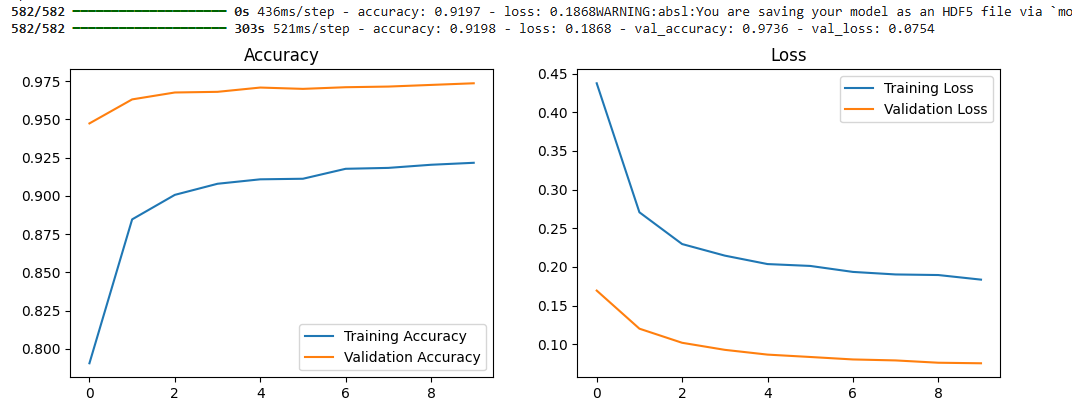

In [ ]:
from google.colab import files
import numpy as np
from PIL import Image
import io

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, 0)  # Create batch
    return img_array

# Option 1: Upload your own image
uploaded = files.upload()

for filename in uploaded.keys():
    # Process the image
    img_array = load_and_preprocess_image(filename)

    # Make prediction
    prediction = model.predict(img_array)
    score = prediction[0][0]

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(Image.open(filename))

    if score > 0.5:
        plt.title(f"Dog ({score:.2f})")
    else:
        plt.title(f"Cat ({1-score:.2f})")
    plt.axis('off')
    plt.show()

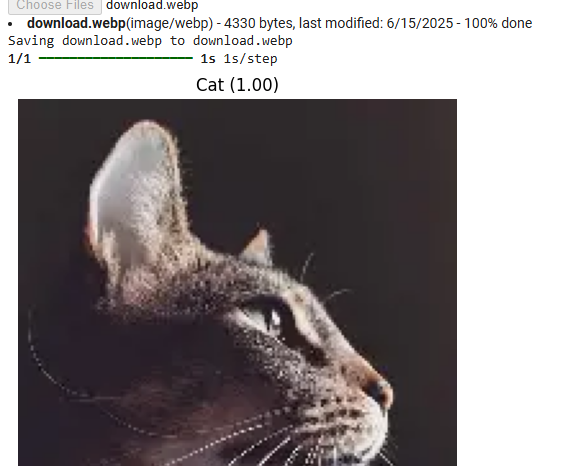

***Troubleshooting Common Errors***

When working with image classification in Colab, you might encounter these common issues:

1. Running Out of Memory
Symptoms: Runtime crashes, “Out of memory” errors
Solutions:
Reduce batch size
Decrease image dimensions
Use data generators instead of loading all images at once
Restart your runtime to clear memory
2. Overfitting
Symptoms: Training accuracy is much higher than validation accuracy
Solutions:
Add more data augmentation
Increase dropout rate
Use regularization (L1 or L2)
Reduce model complexity
3. Poor Model Performance
Symptoms: Low accuracy on both training and validation sets
Solutions:
Train for more epochs
Unfreeze some layers of the base model for fine-tuning
Try a different pre-trained model
Ensure proper class balance in your dataset